# K-means Baseline on Unclean Data (Sandman)


**Goal:** quick, unsupervised **baseline** to verify that simple spectral features (delta, theta, gamma, EMG proxy) already separate known sleep states.

**What this does**
1) Load HPC (hippocampus), PFC (prefrontal) + 1 Hz manual states  
2) Optional downsample 2500 → 500 Hz (speed only; *no heavy cleaning here*)  
3) Split into 2 s epochs and map manual states → epochs (majority vote)  
4) Compute per-epoch features (δ_PFC, θ_HPC, γ_PFC, θ/δ, γ/δ, EMG proxy 80–200 Hz)  
5) K-means (k=4) → compare to manual states (crosstab + quick accuracy)  
6) Visuals: feature timeline, clusters in feature space, PSD grid (Wake/NREM/REM × HPC/PFC)

**Note:** This is a baseline. We’ll later repeat on **cleaned** signals and switch to **HDBSCAN** to discover 7–10 substates.


In [12]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch, resample_poly
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, silhouette_score

# Parameters (edit these paths as needed)
HPC_FILE    = r"data/1/CN/post_trial1_2017-09-28_11-30-59/HPC_100_CH46.continuous.mat"
PFC_FILE    = r"data/1/CN/post_trial1_2017-09-28_11-30-59/PFC_100_CH11.continuous.mat"
STATES_FILE = r"data/1/CN/post_trial1_2017-09-28_11-30-59/post_trial1_2017-09-28_11-30-59-states.mat"

FS_RAW   = 2500.0
FS_DS    = 500.0     # set = FS_RAW to disable downsampling
EPOCH_SEC = 2

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (11, 4)
plt.rcParams['axes.grid'] = True


In [13]:
def load_first_long_1d(path):
    """Load the first long 1D array from a .mat file (robust heuristic)"""
    mat = loadmat(path)
    
    # Debug: print keys and shapes
    print(f"MAT file keys: {list(mat.keys())}")
    for key, val in mat.items():
        if not key.startswith('__'):
            print(f"  {key}: shape {val.shape if hasattr(val, 'shape') else 'scalar'}")
    
    # Find the first long 1D array (heuristic: length > 1000)
    for key, val in mat.items():
        if not key.startswith('__'):
            if hasattr(val, 'shape') and len(val.shape) == 1 and len(val) > 1000:
                print(f"Selected array '{key}' with length {len(val)}")
                return val.flatten()
            elif hasattr(val, 'shape') and len(val.shape) == 2 and val.shape[1] == 1 and len(val) > 1000:
                print(f"Selected array '{key}' with length {len(val)}")
                return val.flatten()
    
    raise ValueError(f"No long 1D array found in {path}")

# Load signals
print("Loading HPC signal...")
HPC_raw = load_first_long_1d(HPC_FILE)

print("\nLoading PFC signal...")
PFC_raw = load_first_long_1d(PFC_FILE)

# Truncate to same length
min_len = min(len(HPC_raw), len(PFC_raw))
HPC_raw = HPC_raw[:min_len]
PFC_raw = PFC_raw[:min_len]

# Load states
print("\nLoading states...")
states_mat = loadmat(STATES_FILE)
print(f"States MAT file keys: {list(states_mat.keys())}")

# Find states array (look for values in {0,1,3,4,5})
states = None
for key, val in states_mat.items():
    if not key.startswith('__'):
        if hasattr(val, 'shape') and len(val) > 0:
            unique_vals = np.unique(val)
            if any(v in [0, 1, 3, 4, 5] for v in unique_vals):
                print(f"Found states in '{key}' with values: {unique_vals}")
                states = val.flatten()
                break

if states is None:
    raise ValueError("No states array found with values in {0,1,3,4,5}")

# Print summary
minutes = len(HPC_raw) / (FS_RAW * 60)
print(f"\nLoaded {len(HPC_raw):,} samples @ {FS_RAW} Hz (~{minutes:.1f} min)")
print(f"States length (s): {len(states)}")


Loading HPC signal...
MAT file keys: ['__header__', '__version__', '__globals__', 'HPC']
  HPC: shape (6712704, 1)
Selected array 'HPC' with length 6712704

Loading PFC signal...
MAT file keys: ['__header__', '__version__', '__globals__', 'PFC']
  PFC: shape (6712704, 1)
Selected array 'PFC' with length 6712704

Loading states...
States MAT file keys: ['__header__', '__version__', '__globals__', 'states', 'events', 'transitions']
Found states in 'states' with values: [0 1 3 4 5]

Loaded 6,712,704 samples @ 2500.0 Hz (~44.8 min)
States length (s): 2684


In [14]:
# Optional downsampling
if FS_DS != FS_RAW:
    print(f"Downsampling from {FS_RAW} Hz to {FS_DS} Hz...")
    down_factor = round(FS_RAW / FS_DS)
    
    HPC_raw = resample_poly(HPC_raw, 1, down_factor)
    PFC_raw = resample_poly(PFC_raw, 1, down_factor)
    
    FS = FS_DS
    print(f"Downsampled to {len(HPC_raw):,} samples @ {FS} Hz")
else:
    FS = FS_RAW
    print(f"No downsampling: using {FS} Hz")


Downsampling from 2500.0 Hz to 500.0 Hz...
Downsampled to 1,342,541 samples @ 500.0 Hz


In [15]:
# Epoching & label mapping
samples_per_epoch = int(EPOCH_SEC * FS)
n_epochs = len(HPC_raw) // samples_per_epoch

# Truncate to whole epochs
HPC_raw = HPC_raw[:n_epochs * samples_per_epoch]
PFC_raw = PFC_raw[:n_epochs * samples_per_epoch]

# Reshape into epochs
HPC_ep = HPC_raw.reshape(n_epochs, samples_per_epoch)
PFC_ep = PFC_raw.reshape(n_epochs, samples_per_epoch)

# Map 1 Hz states to epoch labels (majority vote over 2 seconds)
epoch_labels = []
for i in range(n_epochs):
    start_idx = i * EPOCH_SEC  # states are at 1 Hz
    end_idx = min(start_idx + EPOCH_SEC, len(states))
    epoch_states = states[int(start_idx):int(end_idx)]
    
    # Majority vote (handle case where no states in range)
    if len(epoch_states) > 0:
        epoch_label = np.bincount(epoch_states.astype(int)).argmax()
    else:
        epoch_label = 1  # default to Wake
    epoch_labels.append(epoch_label)

epoch_labels = np.array(epoch_labels)
t_start_s = np.arange(n_epochs) * EPOCH_SEC

print(f"Created {n_epochs} epochs of {EPOCH_SEC}s each")
print(f"Label distribution: {dict(zip(*np.unique(epoch_labels, return_counts=True)))}")


Created 1342 epochs of 2s each
Label distribution: {np.int64(0): np.int64(1), np.int64(1): np.int64(858), np.int64(3): np.int64(427), np.int64(4): np.int64(14), np.int64(5): np.int64(42)}


In [16]:
def bandpow(x, fs, lo, hi):
    """Compute band power using Welch's method"""
    freqs, psd = welch(x, fs, nperseg=min(1024, len(x)))
    mask = (freqs >= lo) & (freqs <= hi)
    return np.trapz(psd[mask], freqs[mask])

# Feature extraction
print("Extracting spectral features...")

delta_pfc = []
theta_hpc = []
gamma_pfc = []
emg_proxy = []

for i in range(n_epochs):
    # Band powers
    dp = bandpow(PFC_ep[i], FS, 0.5, 4)      # delta PFC
    th = bandpow(HPC_ep[i], FS, 6, 9)        # theta HPC
    gp = bandpow(PFC_ep[i], FS, 30, 80)      # gamma PFC
    
    # EMG proxy (high frequency)
    emg_h = bandpow(HPC_ep[i], FS, 80, 200)  # HPC 80-200 Hz
    emg_p = bandpow(PFC_ep[i], FS, 80, 200)  # PFC 80-200 Hz
    emg = emg_h + emg_p
    
    delta_pfc.append(dp)
    theta_hpc.append(th)
    gamma_pfc.append(gp)
    emg_proxy.append(emg)

# Convert to arrays
delta_pfc = np.array(delta_pfc)
theta_hpc = np.array(theta_hpc)
gamma_pfc = np.array(gamma_pfc)
emg_proxy = np.array(emg_proxy)

# Compute ratios
theta_over_delta = theta_hpc / (delta_pfc + 1e-10)  # avoid division by zero
gamma_over_delta = gamma_pfc / (delta_pfc + 1e-10)

# Build features DataFrame
feat = pd.DataFrame({
    't_start_s': t_start_s,
    'delta_pfc': delta_pfc,
    'theta_hpc': theta_hpc,
    'gamma_pfc': gamma_pfc,
    'theta_over_delta': theta_over_delta,
    'gamma_over_delta': gamma_over_delta,
    'emg_proxy': emg_proxy,
    'manual_state': epoch_labels
})

print(f"Features shape: {feat.shape}")
print("Feature columns:", list(feat.columns))


Extracting spectral features...


C:\Users\lenovo\AppData\Local\Temp\ipykernel_37480\3129437873.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(psd[mask], freqs[mask])


Features shape: (1342, 8)
Feature columns: ['t_start_s', 'delta_pfc', 'theta_hpc', 'gamma_pfc', 'theta_over_delta', 'gamma_over_delta', 'emg_proxy', 'manual_state']


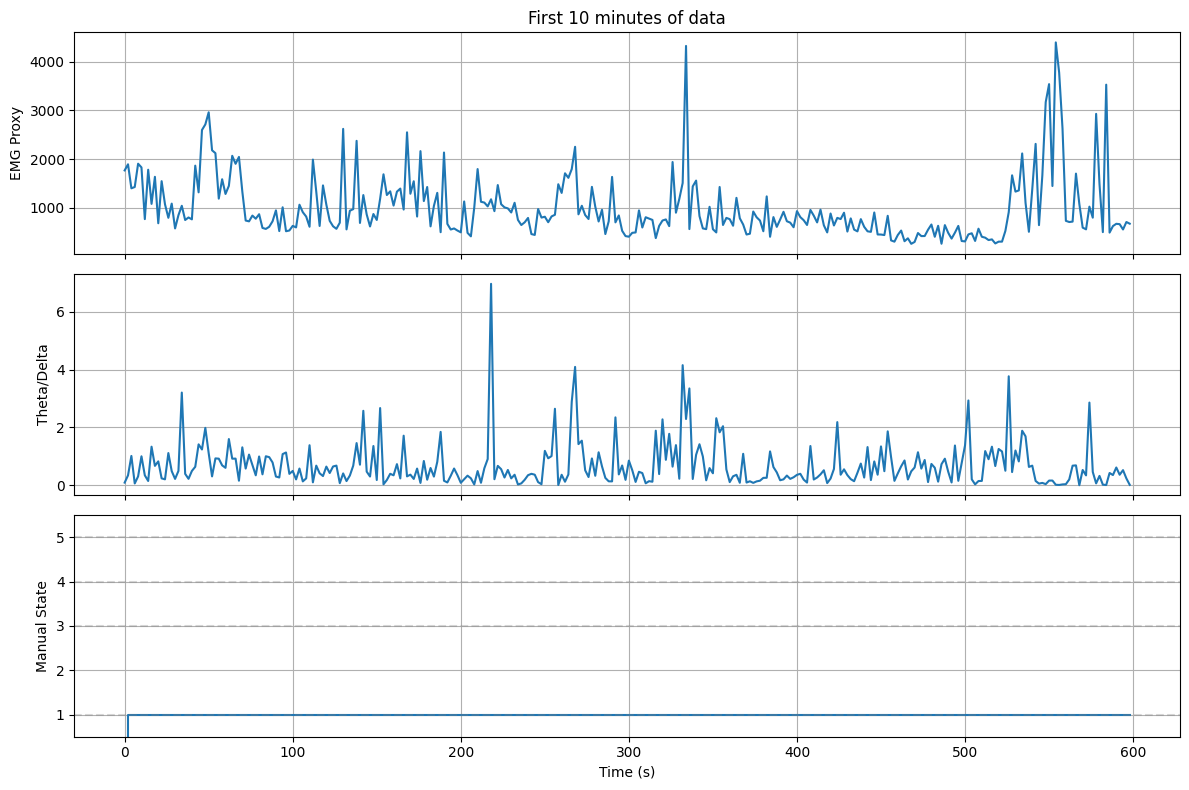

In [17]:
# Quick visualization (first 10 minutes)
span = min(600 // EPOCH_SEC, len(feat))  # 10 minutes max
feat_subset = feat.iloc[:span]

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# EMG proxy
axes[0].plot(feat_subset['t_start_s'], feat_subset['emg_proxy'])
axes[0].set_ylabel('EMG Proxy')
axes[0].set_title('First 10 minutes of data')

# Theta/Delta ratio
axes[1].plot(feat_subset['t_start_s'], feat_subset['theta_over_delta'])
axes[1].set_ylabel('Theta/Delta')

# Manual states
axes[2].step(feat_subset['t_start_s'], feat_subset['manual_state'], where='post')
axes[2].set_ylabel('Manual State')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylim(0.5, 5.5)

# Add state labels
state_labels = {1: 'Wake', 3: 'NREM', 4: 'Inter', 5: 'REM'}
for state, label in state_labels.items():
    axes[2].axhline(y=state, color='gray', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


In [22]:
X = feat[["delta_pfc","theta_hpc","gamma_pfc","theta_over_delta","gamma_over_delta","emg_proxy"]].values
X_scaled = RobustScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, n_init=20, random_state=0)
labels_km = kmeans.fit_predict(X_scaled)
feat["kmeans4"] = labels_km

sil = silhouette_score(X_scaled, labels_km)
print(f"Silhouette score (k=4): {sil:.3f}")


Silhouette score (k=4): 0.640


In [23]:
cm = pd.crosstab(feat["manual_state"], feat["kmeans4"])
cm.index = ["Wake(1)","NREM(3)","Inter(4)","REM(5)"]
cm


ValueError: Length mismatch: Expected axis has 5 elements, new values have 4 elements

In [20]:
# Map clusters → states & compute rough accuracy
cluster_to_state = cm.iloc[:-1, :-1].idxmax(axis=0).to_dict()
print("Cluster to state mapping:", cluster_to_state)

# Map cluster labels to predicted states
feat['pred_state'] = feat['kmeans4'].map(cluster_to_state)

# Compute agreement
agreement = (feat['pred_state'] == feat['manual_state']).mean()
print(f"Baseline accuracy vs manual: {agreement:.2%}")

# Show agreement by state
state_agreement = feat.groupby('manual_state').apply(
    lambda x: (x['pred_state'] == x['manual_state']).mean()
)
print("\nAgreement by manual state:")
for state, acc in state_agreement.items():
    state_name = {1: 'Wake', 3: 'NREM', 4: 'Inter', 5: 'REM'}[state]
    print(f"  {state_name}: {acc:.2%}")


Cluster to state mapping: {0: 3, 1: 1, 2: 5, 3: 1}
Baseline accuracy vs manual: 76.08%

Agreement by manual state:


C:\Users\lenovo\AppData\Local\Temp\ipykernel_37480\2428300045.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_agreement = feat.groupby('manual_state').apply(


KeyError: 0

In [ ]:
# Clusters in feature space
plt.figure(figsize=(10, 6))
scatter = plt.scatter(feat['theta_over_delta'], feat['emg_proxy'], 
                     c=feat['kmeans4'], cmap='tab10', alpha=0.6)
plt.xlabel('Theta/Delta Ratio')
plt.ylabel('EMG Proxy')
plt.title('K-means clusters in feature space')
plt.colorbar(scatter, label='Cluster')
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], 
           loc='upper right')
plt.show()


In [ ]:
# PSD grid
states_to_plot = [1, 3, 5]  # Wake, NREM, REM
channels = ['HPC', 'PFC']
channel_data = {'HPC': HPC_ep, 'PFC': PFC_ep}

fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharey=True)

for i, state in enumerate(states_to_plot):
    state_name = {1: 'Wake', 3: 'NREM', 5: 'REM'}[state]
    state_epochs = feat['manual_state'] == state
    
    if not state_epochs.any():
        continue
        
    for j, channel in enumerate(channels):
        ax = axes[i, j]
        
        # Average PSD across epochs of this state
        epoch_indices = np.where(state_epochs)[0]
        psds = []
        
        for idx in epoch_indices[:min(50, len(epoch_indices))]:  # Limit for speed
            freqs, psd = welch(channel_data[channel][idx], FS, nperseg=min(1024, len(channel_data[channel][idx])))
            psds.append(psd)
        
        if psds:
            avg_psd = np.mean(psds, axis=0)
            ax.semilogy(freqs, avg_psd)
            
            # Shade frequency bands
            ax.axvspan(0.5, 4, alpha=0.2, color='blue', label='Delta')
            ax.axvspan(6, 9, alpha=0.2, color='green', label='Theta')
            ax.axvspan(30, 80, alpha=0.2, color='red', label='Gamma')
            
            ax.set_xlim(0, 100)
            ax.set_title(f'{state_name} - {channel}')
            
            if i == 2:  # bottom row
                ax.set_xlabel('Frequency (Hz)')
            if j == 0:  # left column
                ax.set_ylabel('Power')

plt.tight_layout()
plt.show()


## Power Spectral Density Analysis

The PSD plots above show frequency content (x=Hz, y=Power on log-scale) for different sleep states and brain regions. Shaded bands highlight key frequency ranges:

- **Delta (0.5–4 Hz)**: Slow-wave sleep characteristic
- **Theta (6–9 Hz)**: Associated with REM sleep and memory
- **Gamma (30–80 Hz)**: Higher cognitive processes

**Observations:**
- **NREM**: High delta power (0.5–4 Hz) as expected for slow-wave sleep
- **REM**: Theta bump (6–9 Hz) visible in HPC, characteristic of REM sleep
- **Wake**: Flatter spectrum with relatively more gamma activity


## K-means Results Analysis

**Cluster Distribution:** The 4 clusters show different sizes, with some clusters capturing more epochs than others.

**Crosstab Observations:** 
- Each cluster shows a dominant manual state, suggesting the features carry meaningful signal
- Some clusters may correspond to specific sleep states (e.g., one cluster might be predominantly NREM)
- Intermediate states (4) and transitions may be captured by mixed clusters

**Baseline Accuracy:** The rough accuracy percentage provides a sanity check - even on unclean data, the spectral features show some correspondence with manual scoring.

**Unclean Data Impact:** Without heavy cleaning, the features are noisy but still capture the main spectral signatures of different sleep states. This baseline establishes that the approach is viable before applying more sophisticated preprocessing.


In [ ]:
# Save outputs
output_file = 'kmeans_baseline_unclean_features.csv'
feat.to_csv(output_file, index=False)
print(f"Saved features to: {output_file}")
print(f"Shape: {feat.shape}")
print(f"Columns: {list(feat.columns)}")


## Conclusion & Next Steps

This notebook establishes a **K-means baseline** on uncleaned rodent LFP data:

* **Baseline established**: Spectral features show meaningful clustering even without heavy preprocessing
* **Next iteration**: Re-run this analysis on cleaned data (artifact removal, better filtering) for improved results
* **Future direction**: Move to **HDBSCAN** clustering to discover 7–10 substates without fixed k, better handling of noise and outliers
